# Cell 1: Setup and Imports

In [48]:
# Part 0: Setup and Imports

# --- Data Manipulation & Analysis ---
import pandas as pd
import numpy as np
import re
from collections import Counter
import os

# --- Persian Text Processing ---
from hazm import word_tokenize
import arabic_reshaper
from bidi.algorithm import get_display
from parsivar import Normalizer, Tokenizer, FindStems

# --- Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# --- Machine Learning ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Helper Functions Definition ---
def load_stopwords_from_file(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            stopwords = set(line.strip() for line in f)
        return stopwords
    except FileNotFoundError:
        print(f"Warning: Stopwords file not found at '{filepath}'. Returning an empty set.")
        return set()


my_normalizer = Normalizer()
my_tokenizer = Tokenizer()
my_stemmer = FindStems()

def preprocess_text(text, stopwords_set):
    if not isinstance(text, str):
        return ""
    
    normalized_text = my_normalizer.normalize(text)
    
    tokens = my_tokenizer.tokenize_words(normalized_text)
    
    stemmed_tokens = [my_stemmer.convert_to_stem(word) for word in tokens]
    
    filtered_tokens = [word for word in stemmed_tokens if word not in stopwords_set and '&' not in word]
    
    return ' '.join(filtered_tokens)


def create_wordcloud(text, title, filename, font_path):
    if not text.strip():
        print(f"No text available to create word cloud for '{title}'. Skipping this step.")
        return

    words = text.split()
    word_counts = Counter(words)

    processed_word_counts = {}
    for word, count in word_counts.items():
        reshaped_word = arabic_reshaper.reshape(word)
        processed_word_counts[reshaped_word] = count

    wordcloud = WordCloud(
        width=800, height=600, background_color='black', font_path=font_path
    ).generate_from_frequencies(processed_word_counts)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(get_display(arabic_reshaper.reshape(title)))
    plt.savefig(filename)
    plt.show()
    plt.close()
    print(f"Word cloud for '{title}' saved as {filename}.")

    
def plot_most_common_words(text, title, filename, n_words=20):
    if not text.strip():
        print(f"No text available to create frequency chart for '{title}'. Skipping this step.")
        return
        
    words = text.split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(n_words)
    words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
    words_df['reshaped_word'] = words_df['word'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))

    plt.figure(figsize=(12, 8))
    plt.barh(words_df['reshaped_word'], words_df['count'], color='teal')
    plt.xlabel(get_display(arabic_reshaper.reshape('تعداد تکرار')))
    plt.title(get_display(arabic_reshaper.reshape(title)))
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()
    print(f"Word frequency chart for '{title}' saved as {filename}.")


def plot_confusion_matrix(y_true, y_pred, model_name, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    
    title = f'ماتریس درهم ریختگی {model_name}'
    reshaped_title = arabic_reshaper.reshape(title)
    bidi_title = get_display(reshaped_title)
    plt.title(bidi_title, fontsize=16)
    
    plt.xlabel(get_display(arabic_reshaper.reshape('پیش‌بینی شده')), fontsize=12)
    plt.ylabel(get_display(arabic_reshaper.reshape('واقعی')), fontsize=12)
    
    figures_dir = os.path.join('..', 'figures')
    os.makedirs(figures_dir, exist_ok=True)
    filename = f"confusion_matrix_{model_name.replace(' ', '_')}.png"
    full_path = os.path.join(figures_dir, filename)

    plt.savefig(full_path)
    plt.show()
    print(f"Confusion matrix chart for '{model_name}' saved as '{filename}'.")

print("All libraries and helper functions are loaded.")

All libraries and helper functions are loaded.


# Cell 2: Initial Data Loading & Exploration

In [51]:
# Part 1: Initial Data Loading & Exploration

data_path = os.path.join('..', 'data', 'digikala_comments.csv')
df_raw = pd.read_csv(data_path)

print("--- Raw Data Sample ---")
display(df_raw.head())

print("\n--- Raw Data Info ---")
df_raw.info()

print("\n--- Raw Rating Distribution ---")
print(df_raw['rating'].value_counts())

--- Raw Data Sample ---


,rating,date,comment,product_url
0,2.3,۱۲ مرداد ۱۳۹۸,خیلی عالی نیست ولی خوبه. تو نصبش خیلی جا به جا...,https://www.digikala.com/product/dkp-1716732/%...
1,NaN,۲۹ مرداد ۱۳۹۸,هر دو دستمال خشک بود درحالیکه یکی باید مرطوب ب...,https://www.digikala.com/product/dkp-1716732/%...
2,5.0,۸ مهر ۱۳۹۸,فوق العادست.,https://www.digikala.com/product/dkp-1716732/%...
3,3.0,۱۸ مرداد ۱۳۹۸,چسبش چنگی به دل نمیزد,https://www.digikala.com/product/dkp-1716732/%...
4,2.5,۲۹ آذر ۱۳۹۸,با توجه به قیمتش خوبه ولی برشش زیاد دقیق نیست ...,https://www.digikala.com/product/dkp-1716732/%...



--- Raw Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11378 entries, 0 to 11377
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rating       11063 non-null  object
 1   date         11318 non-null  object
 2   comment      11370 non-null  object
 3   product_url  11378 non-null  object
dtypes: object(4)
memory usage: 355.7+ KB

--- Raw Rating Distribution ---
rating
5.0              6032
4.0              2392
3.0              1078
1.0               971
2.0               371
0.0                58
4.3                19
4.8                14
4.5                13
4.4                11
4.6                11
3.8                10
3.3                 9
4.2                 9
4.1                 6
4.7                 5
3.4                 5
3.6                 5
3.7                 4
Parsing Error       4
1.3                 4
3.5                 3
1.5                 3
2.3                 3
2.8          

# Cell 3 : Data Cleaning & Preprocessing

In [54]:
# Part 2: Data Cleaning & Preprocessing

df = df_raw.copy()

df.dropna(subset=['rating', 'comment'], inplace=True)
df = df[~df['rating'].isin(['N/A', 'Parsing Error'])]


df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df.dropna(subset=['rating'], inplace=True)
df['rating'] = df['rating'].round().astype(int)


df = df[df['rating'].isin([0, 1, 2, 4, 5])]
df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)


stopwords_filepath = 'persian_stopwords.txt'
persian_stopwords = load_stopwords_from_file(stopwords_filepath)
df['cleaned_comment'] = df['comment'].apply(lambda text: preprocess_text(text, persian_stopwords))


df_cleaned = df[['rating', 'sentiment', 'cleaned_comment', 'comment']].copy()
df_cleaned.dropna(subset=['cleaned_comment'], inplace=True)

output_dir = os.path.join('..', 'data')
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, 'cleaned_digikala_comments.csv')

df_cleaned.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Data cleaning and preprocessing complete. Cleaned data saved to '{output_filename}'.")


print("\n--- Cleaned Data Sample ---")
display(df_cleaned.head())

print("\n--- Cleaned Data Info ---")
df_cleaned.info()

print("\n--- Final Rating Distribution ---")
print(df_cleaned['rating'].value_counts())

print("\n--- Final Sentiment Distribution ---")
print(df_cleaned['sentiment'].value_counts())

Data cleaning and preprocessing complete. Cleaned data saved to '..\data\cleaned_digikala_comments.csv'.

--- Cleaned Data Sample ---


,rating,sentiment,cleaned_comment,comment
0,2,0,خیلی عالی نیست ولی خوبه نصب خیلی جا جا میشه الکی,خیلی عالی نیست ولی خوبه. تو نصبش خیلی جا به جا...
2,5,1,فوق العادست,فوق العادست.
4,2,0,توجه قیمت خوبه ولی برش زیاد دقیق نیست اگه دست ...,با توجه به قیمتش خوبه ولی برشش زیاد دقیق نیست ...
5,5,1,باتوجه ضخامت کم سالم ماندن دوربین جدید جلوگیری...,باتوجه به ضخامت کم گوشیها برای سالم ماندن دورب...
6,0,0,کاملا مناسبه لنز محافظت میکنه,کاملا مناسبه و از لنز محافظت میکنه



--- Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 9957 entries, 0 to 11377
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rating           9957 non-null   int32 
 1   sentiment        9957 non-null   int64 
 2   cleaned_comment  9957 non-null   object
 3   comment          9957 non-null   object
dtypes: int32(1), int64(1), object(2)
memory usage: 350.1+ KB

--- Final Rating Distribution ---
rating
5    6062
4    2474
1     976
2     383
0      62
Name: count, dtype: int64

--- Final Sentiment Distribution ---
sentiment
1    8536
0    1421
Name: count, dtype: int64


# Cell 4 : Exploratory Data Analysis (EDA)

--- Descriptive Statistics ---
Average comment length (number of words): 12.40

Sentiment Distribution (1: Positive, 0: Negative):
 sentiment
1    8536
0    1421
Name: count, dtype: int64


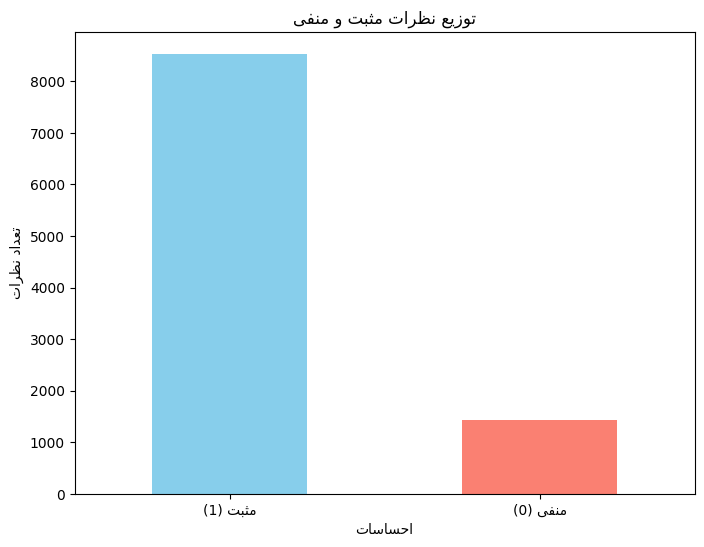


Sentiment distribution chart saved as '..\figures\sentiment_distribution.png'.

--- Plotting Final Rating Distribution ---


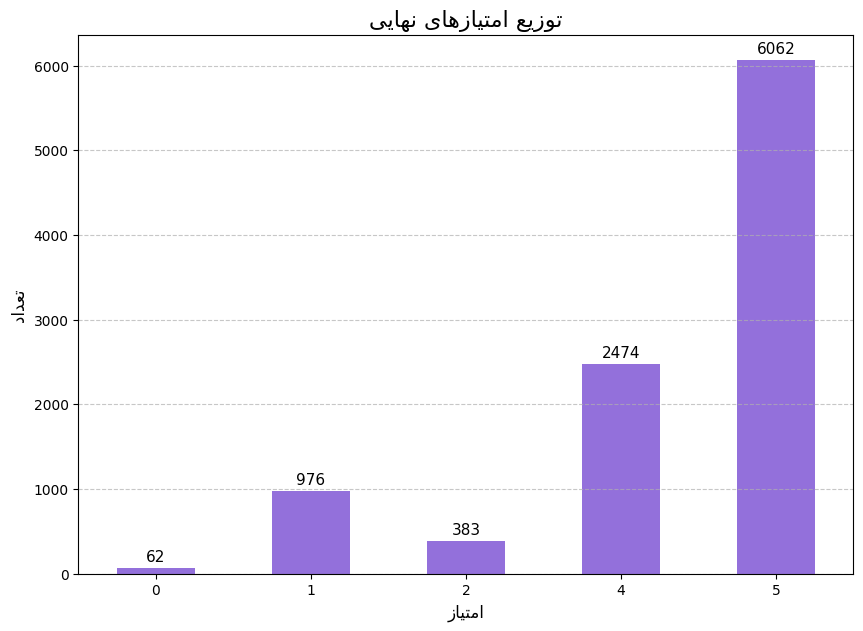

Final rating distribution chart saved as '..\figures\final_rating_distribution.png'


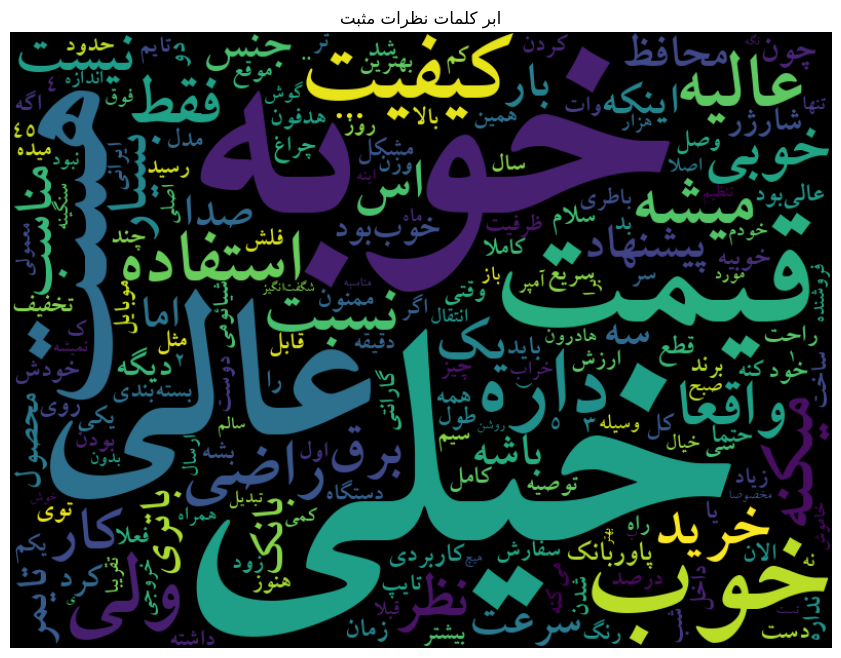

Word cloud for 'ابر کلمات نظرات مثبت' saved as ..\figures\positive_wordcloud.png.


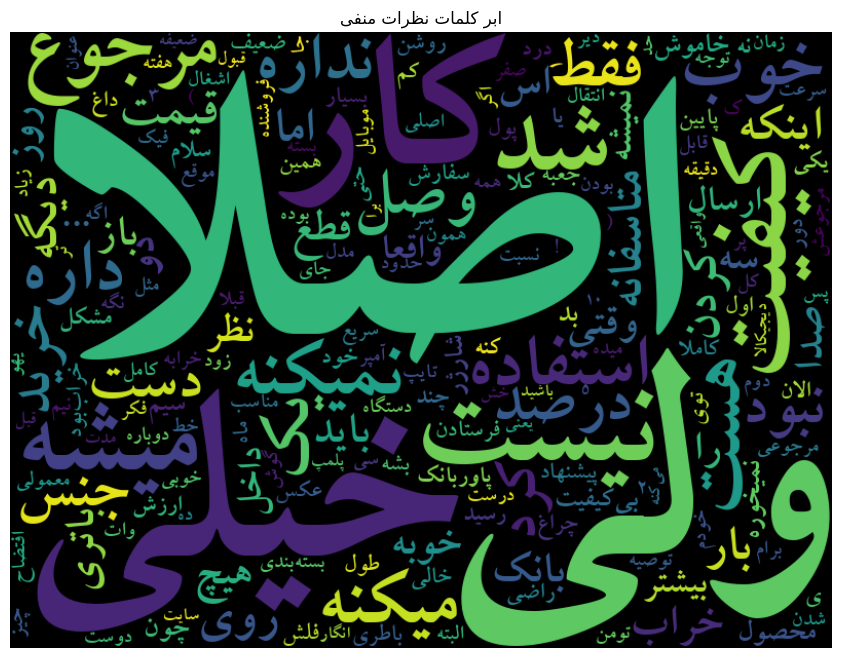

Word cloud for 'ابر کلمات نظرات منفی' saved as ..\figures\negative_wordcloud.png.


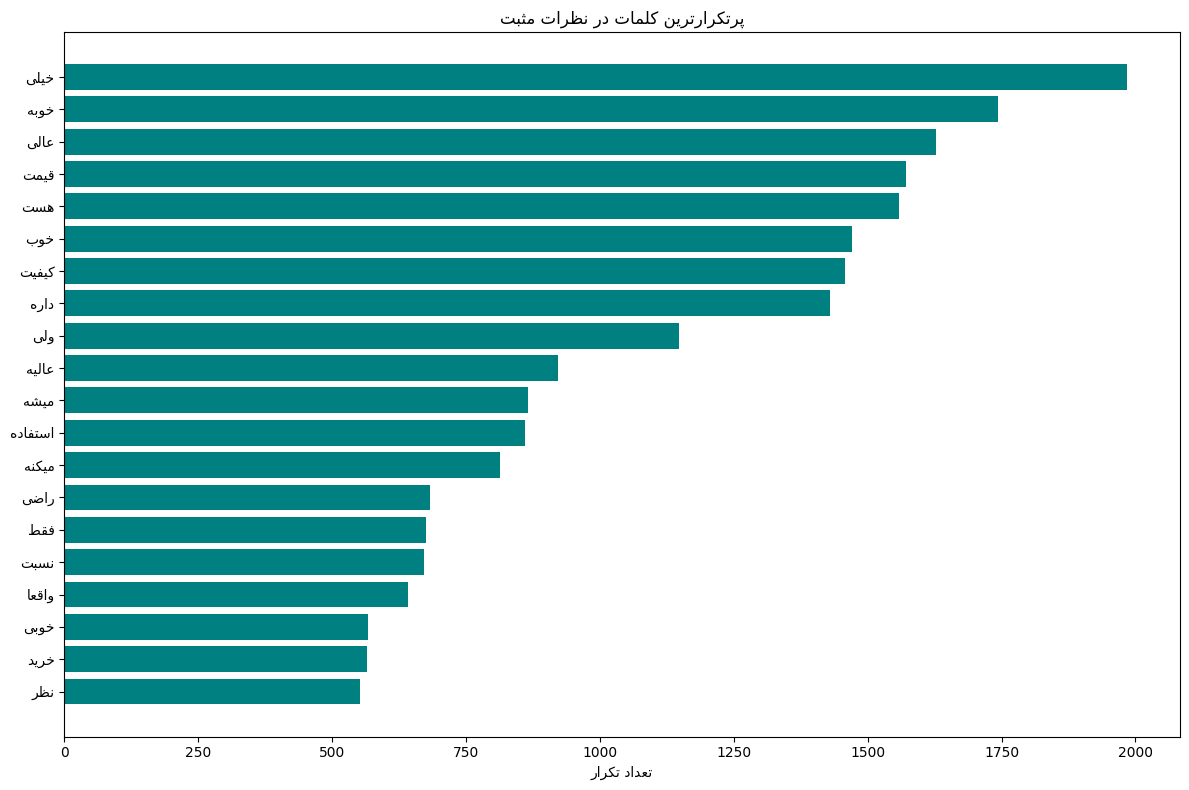

Word frequency chart for 'پرتکرارترین کلمات در نظرات مثبت' saved as ..\figures\positive_frequent_words.png.


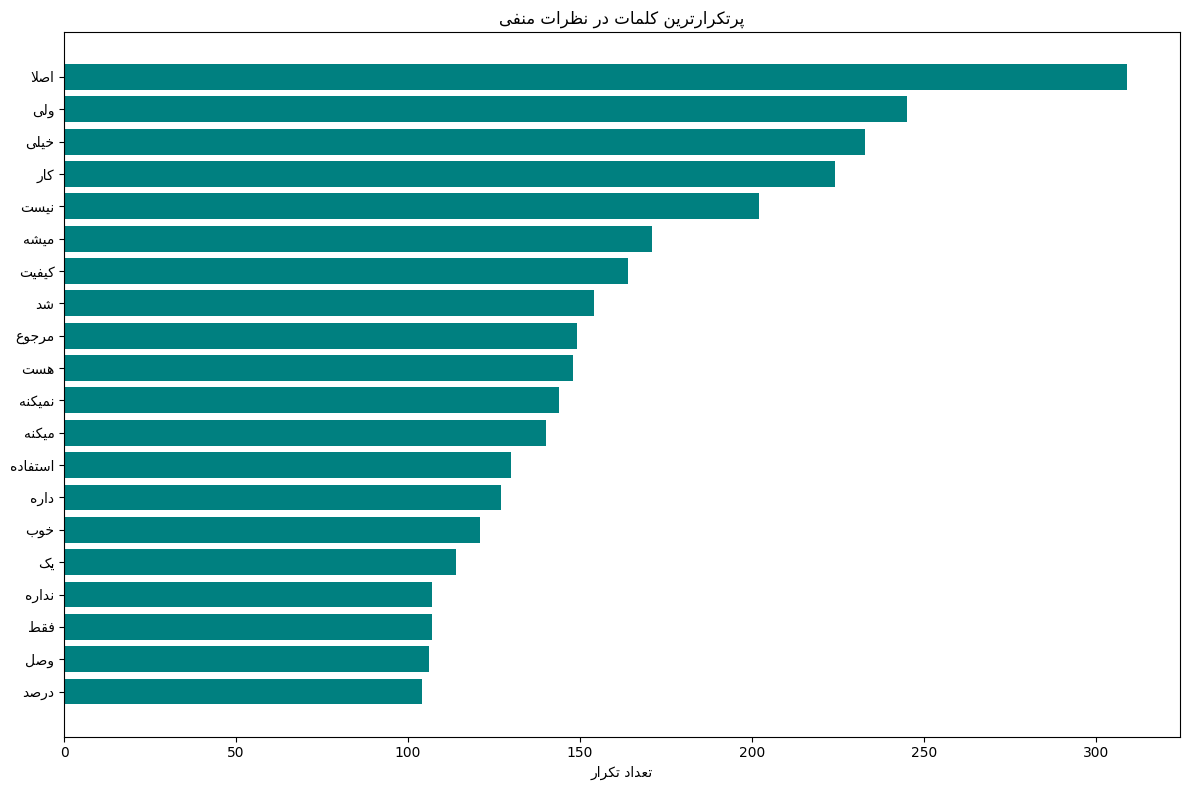

Word frequency chart for 'پرتکرارترین کلمات در نظرات منفی' saved as ..\figures\negative_frequent_words.png.

--- Exploratory Data Analysis completed successfully. ---


In [56]:
# Part 3: Exploratory Data Analysis (EDA)

figures_dir = os.path.join('..', 'figures')
os.makedirs(figures_dir, exist_ok=True)

print("--- Descriptive Statistics ---")
df_cleaned['comment_length'] = df_cleaned['cleaned_comment'].apply(lambda x: len(str(x).split()))
print(f"Average comment length (number of words): {df_cleaned['comment_length'].mean():.2f}")

sentiment_dist = df_cleaned['sentiment'].value_counts()
print("\nSentiment Distribution (1: Positive, 0: Negative):\n", sentiment_dist)

plt.figure(figsize=(8, 6))
sentiment_dist.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title(get_display(arabic_reshaper.reshape('توزیع نظرات مثبت و منفی')))
plt.xlabel(get_display(arabic_reshaper.reshape('احساسات')))
plt.ylabel(get_display(arabic_reshaper.reshape('تعداد نظرات')))
plt.xticks(ticks=[0, 1], labels=[get_display(arabic_reshaper.reshape('مثبت (1)')), get_display(arabic_reshaper.reshape('منفی (0)'))], rotation=0)
plt.savefig(os.path.join(figures_dir, 'sentiment_distribution.png'))
plt.show()
plt.close()
print(f"\nSentiment distribution chart saved as '{os.path.join(figures_dir, 'sentiment_distribution.png')}'.")



print("\n--- Plotting Final Rating Distribution ---")
final_rating_dist = df_cleaned['rating'].value_counts().sort_index()

plt.figure(figsize=(10, 7))
bars = final_rating_dist.plot(kind='bar', color='mediumpurple', rot=0)
plt.title(get_display(arabic_reshaper.reshape('توزیع امتیازهای نهایی')), fontsize=16)
plt.xlabel(get_display(arabic_reshaper.reshape('امتیاز')), fontsize=12)
plt.ylabel(get_display(arabic_reshaper.reshape('تعداد')), fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=11, xytext=(0, 8),
                   textcoords='offset points')

plt.savefig(os.path.join(figures_dir, 'final_rating_distribution.png'))
plt.show()
print(f"Final rating distribution chart saved as '{os.path.join(figures_dir, 'final_rating_distribution.png')}'")


positive_text = ' '.join(df_cleaned[df_cleaned['sentiment'] == 1]['cleaned_comment'].astype(str))
negative_text = ' '.join(df_cleaned[df_cleaned['sentiment'] == 0]['cleaned_comment'].astype(str))

font_path = 'B Lotus Bold.ttf'

if not os.path.exists(font_path):
    print(f"\nError: Font file not found at '{font_path}'. Word clouds and charts will not be generated.")
else:
    create_wordcloud(positive_text, 'ابر کلمات نظرات مثبت', 
                     os.path.join(figures_dir, 'positive_wordcloud.png'), font_path)
    create_wordcloud(negative_text, 'ابر کلمات نظرات منفی', 
                     os.path.join(figures_dir, 'negative_wordcloud.png'), font_path)
    plot_most_common_words(positive_text, 'پرتکرارترین کلمات در نظرات مثبت',
                           os.path.join(figures_dir, 'positive_frequent_words.png'))
    plot_most_common_words(negative_text, 'پرتکرارترین کلمات در نظرات منفی',
                           os.path.join(figures_dir, 'negative_frequent_words.png'))

print("\n--- Exploratory Data Analysis completed successfully. ---")

# Cell 5 : Text Vectorization

In [59]:
# Part 4: Text Vectorization

X_features = df_cleaned['cleaned_comment'].astype(str)
y = df_cleaned['sentiment']

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 3))
X = vectorizer.fit_transform(X_features)

print("--- Vectorization Output ---")
print(f"Dimensions of feature matrix (X): {X.shape}")
print(f"Number of target labels (y): {y.shape[0]}")

--- Vectorization Output ---
Dimensions of feature matrix (X): (9957, 3000)
Number of target labels (y): 9957


# Cell 6 : Modeling and Evaluation

Training samples: 7965, Test samples: 1992

--- Training and Evaluating Logistic Regression ---
Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

    منفی (0)       0.62      0.77      0.68       284
    مثبت (1)       0.96      0.92      0.94      1708

    accuracy                           0.90      1992
   macro avg       0.79      0.85      0.81      1992
weighted avg       0.91      0.90      0.90      1992



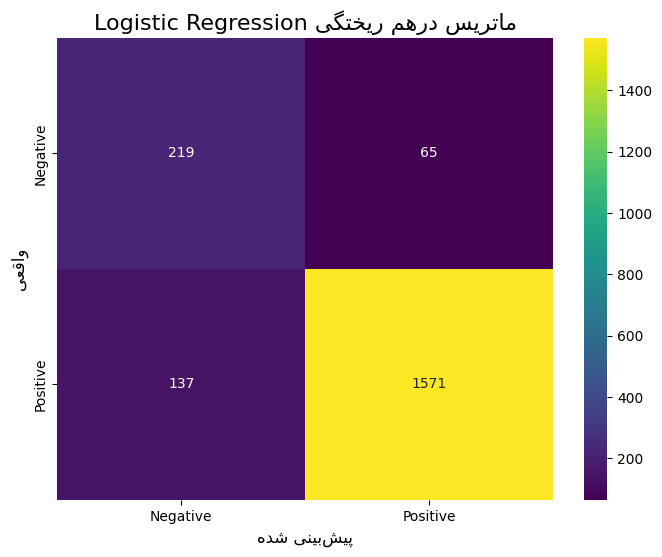

Confusion matrix chart for 'Logistic Regression' saved as 'confusion_matrix_Logistic_Regression.png'.
--------------------------------------------------

--- Training and Evaluating Multinomial Naive Bayes ---
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

    منفی (0)       0.89      0.41      0.56       284
    مثبت (1)       0.91      0.99      0.95      1708

    accuracy                           0.91      1992
   macro avg       0.90      0.70      0.76      1992
weighted avg       0.91      0.91      0.89      1992



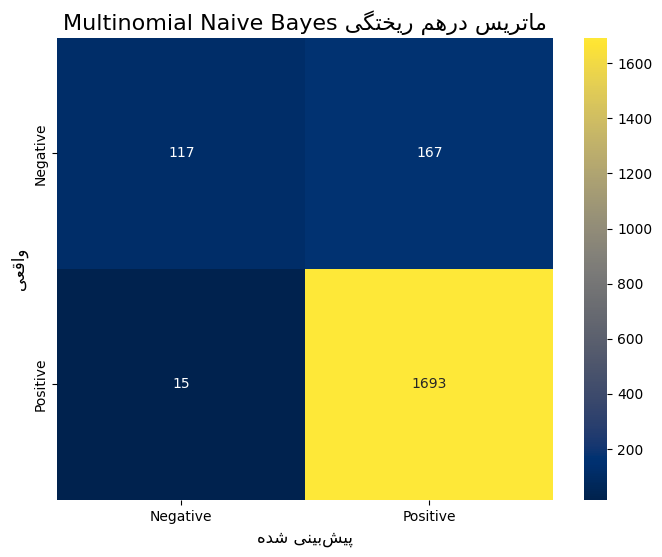

Confusion matrix chart for 'Multinomial Naive Bayes' saved as 'confusion_matrix_Multinomial_Naive_Bayes.png'.
--------------------------------------------------

--- Training and Evaluating Support Vector Machine ---
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

    منفی (0)       0.70      0.69      0.70       284
    مثبت (1)       0.95      0.95      0.95      1708

    accuracy                           0.91      1992
   macro avg       0.83      0.82      0.82      1992
weighted avg       0.91      0.91      0.91      1992



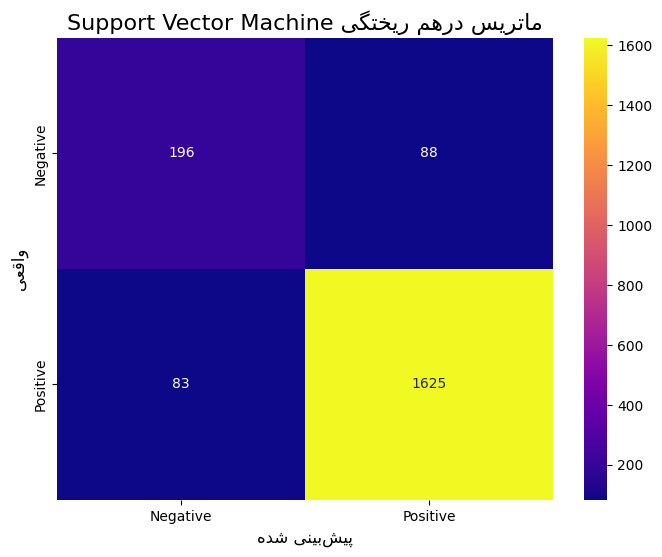

Confusion matrix chart for 'Support Vector Machine' saved as 'confusion_matrix_Support_Vector_Machine.png'.
--------------------------------------------------

--- Training and Evaluating Random Forest ---
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

    منفی (0)       0.72      0.58      0.64       284
    مثبت (1)       0.93      0.96      0.95      1708

    accuracy                           0.91      1992
   macro avg       0.83      0.77      0.80      1992
weighted avg       0.90      0.91      0.90      1992



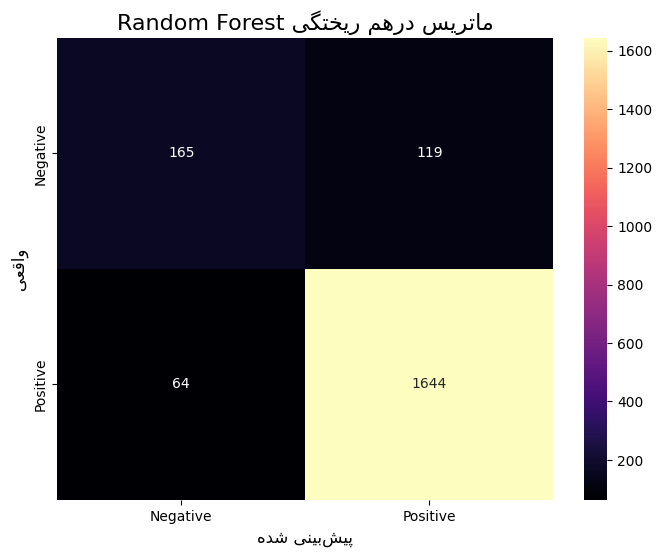

Confusion matrix chart for 'Random Forest' saved as 'confusion_matrix_Random_Forest.png'.
--------------------------------------------------



In [62]:
# Part 5: Modeling and Evaluation

# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}\n")

# 2. تعریف مدل‌ها و رنگ‌های نمودار
models = {
    "Logistic Regression": LogisticRegression(C=10, solver='liblinear', random_state=42, max_iter=1000, class_weight='balanced'),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
}
model_colors = {
    "Logistic Regression": "viridis",
    "Multinomial Naive Bayes": "cividis",
    "Support Vector Machine": "plasma",
    "Random Forest": "magma"
}

# 3. Trainig and Evaluate the Models
for name, model in models.items():
    print(f"--- Training and Evaluating {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['منفی (0)', 'مثبت (1)']))
    
    cmap_color = model_colors.get(name, 'viridis')
    plot_confusion_matrix(y_test, y_pred, name, cmap=cmap_color)
    print("-" * 50 + "\n")